# Check your GPU (P100 or V100 recommended)

In [ ]:
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv
print("GPU: " + gpu[1])

GPU: Tesla P100-PCIE-16GB


# Set Up Google Drive

You don't need to run this if you don't want to save your results to your  Drive.

In [ ]:
import os
from google.colab import drive
driveMountPath = "/content/drive/"
drive.mount(driveMountPath)

#@markdown Your relative Google Drive path that will be used to store Big Sleep results:
driveRelPath = "My Drive/BigSleep/" #@param{type:"string"}
drivePath = os.path.join(driveMountPath, driveRelPath) 

# Prepare (Needs to be run once after every restart or new session)

Import the usual libraries, load up CLIP, define helper functions, alter BigGAN

In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output

In [ ]:
%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch


import numpy as np

# Load the model
# perceptor, preprocess = clip.load('ViT-B/32')
perceptor, preprocess = clip.load('ViT-B/32', jit=False)

/content
Cloning into 'CLIP'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.
/content/CLIP
     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=9d076e95b6903db0f967278a5f9f4c9b289019b5a4710007649eab469b9b8b85
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy


100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 67.0MiB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
itt = 0

from pathlib import Path

def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  print("Displaying Iteration " + str(itt))
  return display.Image(str(3)+'.png')

def displSample(img, path):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if(itt > 0 and path and os.path.exists(Path(path).parent)):
    imageio.imwrite(path, np.array(img))
  imageio.imwrite(str(3) + '.png', np.array(img))
  print("Displaying Iteration " + str(itt))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

In [ ]:
!pip install pytorch-pretrained-biggan

import torch.nn as nn
import torch.nn.functional as F
import math
import json
import logging
import os
import shutil
import tempfile
from functools import wraps
from hashlib import sha256
import sys
from io import open

import boto3
import requests
from botocore.exceptions import ClientError
from tqdm import tqdm

try:
    from urllib.parse import urlparse
except ImportError:
    from urlparse import urlparse

try:
    from pathlib import Path
    PYTORCH_PRETRAINED_BIGGAN_CACHE = Path(os.getenv('PYTORCH_PRETRAINED_BIGGAN_CACHE',
                                                   Path.home() / '.pytorch_pretrained_biggan'))
except (AttributeError, ImportError):
    PYTORCH_PRETRAINED_BIGGAN_CACHE = os.getenv('PYTORCH_PRETRAINED_BIGGAN_CACHE',
                                              os.path.join(os.path.expanduser("~"), '.pytorch_pretrained_biggan'))

logger = logging.getLogger(__name__)  # pylint: disable=invalid-name


def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    return filename


def filename_to_url(filename, cache_dir=None):
    """
    Return the url and etag (which may be ``None``) stored for `filename`.
    Raise ``EnvironmentError`` if `filename` or its stored metadata do not exist.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    cache_path = os.path.join(cache_dir, filename)
    if not os.path.exists(cache_path):
        raise EnvironmentError("file {} not found".format(cache_path))

    meta_path = cache_path + '.json'
    if not os.path.exists(meta_path):
        raise EnvironmentError("file {} not found".format(meta_path))

    with open(meta_path, encoding="utf-8") as meta_file:
        metadata = json.load(meta_file)
    url = metadata['url']
    etag = metadata['etag']

    return url, etag


def cached_path(url_or_filename, cache_dir=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    parsed = urlparse(url_or_filename)

    if parsed.scheme in ('http', 'https', 's3'):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif parsed.scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))


def split_s3_path(url):
    """Split a full s3 path into the bucket name and path."""
    parsed = urlparse(url)
    if not parsed.netloc or not parsed.path:
        raise ValueError("bad s3 path {}".format(url))
    bucket_name = parsed.netloc
    s3_path = parsed.path
    # Remove '/' at beginning of path.
    if s3_path.startswith("/"):
        s3_path = s3_path[1:]
    return bucket_name, s3_path


def s3_request(func):
    """
    Wrapper function for s3 requests in order to create more helpful error
    messages.
    """

    @wraps(func)
    def wrapper(url, *args, **kwargs):
        try:
            return func(url, *args, **kwargs)
        except ClientError as exc:
            if int(exc.response["Error"]["Code"]) == 404:
                raise EnvironmentError("file {} not found".format(url))
            else:
                raise

    return wrapper


@s3_request
def s3_etag(url):
    """Check ETag on S3 object."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_object = s3_resource.Object(bucket_name, s3_path)
    return s3_object.e_tag


@s3_request
def s3_get(url, temp_file):
    """Pull a file directly from S3."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_resource.Bucket(bucket_name).download_fileobj(s3_path, temp_file)


def http_get(url, temp_file):
    req = requests.get(url, stream=True)
    content_length = req.headers.get('Content-Length')
    total = int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", total=total)
    for chunk in req.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()


def get_from_cache(url, cache_dir=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url)
    else:
        response = requests.head(url, allow_redirects=True)
        if response.status_code != 200:
            raise IOError("HEAD request failed for url {} with status code {}"
                          .format(url, response.status_code))
        etag = response.headers.get("ETag")

    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    if not os.path.exists(cache_path):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with tempfile.NamedTemporaryFile() as temp_file:
            logger.info("%s not found in cache, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                s3_get(url, temp_file)
            else:
                http_get(url, temp_file)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            logger.info("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            logger.info("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w', encoding="utf-8") as meta_file:
                json.dump(meta, meta_file)

            logger.info("removing temp file %s", temp_file.name)

    return cache_path


def read_set_from_file(filename):
    '''
    Extract a de-duped collection (set) of text from a file.
    Expected file format is one item per line.
    '''
    collection = set()
    with open(filename, 'r', encoding='utf-8') as file_:
        for line in file_:
            collection.add(line.rstrip())
    return collection


def get_file_extension(path, dot=True, lower=True):
    ext = os.path.splitext(path)[1]
    ext = ext if dot else ext[1:]
    return ext.lower() if lower else ext


PRETRAINED_MODEL_ARCHIVE_MAP = {
    'biggan-deep-128': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-128-pytorch_model.bin",
    'biggan-deep-256': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-256-pytorch_model.bin",
    'biggan-deep-512': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-512-pytorch_model.bin",
}

PRETRAINED_CONFIG_ARCHIVE_MAP = {
    'biggan-deep-128': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-128-config.json",
    'biggan-deep-256': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-256-config.json",
    'biggan-deep-512': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-512-config.json",
}

WEIGHTS_NAME = 'pytorch_model.bin'
CONFIG_NAME = 'config.json'
import copy
import json

class BigGANConfig(object):
    """ Configuration class to store the configuration of a `BigGAN`. 
        Defaults are for the 128x128 model.
        layers tuple are (up-sample in the layer ?, input channels, output channels)
    """
    def __init__(self,
                 output_dim=128,
                 z_dim=128,
                 class_embed_dim=128,
                 channel_width=128,
                 num_classes=1000,
                 layers=[(False, 16, 16),
                         (True, 16, 16),
                         (False, 16, 16),
                         (True, 16, 8),
                         (False, 8, 8),
                         (True, 8, 4),
                         (False, 4, 4),
                         (True, 4, 2),
                         (False, 2, 2),
                         (True, 2, 1)],
                 attention_layer_position=8,
                 eps=1e-4,
                 n_stats=51):
        """Constructs BigGANConfig. """
        self.output_dim = output_dim
        self.z_dim = z_dim
        self.class_embed_dim = class_embed_dim
        self.channel_width = channel_width
        self.num_classes = num_classes
        self.layers = layers
        self.attention_layer_position = attention_layer_position
        self.eps = eps
        self.n_stats = n_stats

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BigGANConfig` from a Python dictionary of parameters."""
        config = BigGANConfig()
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BigGANConfig` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"







def snconv2d(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Conv2d(**kwargs), eps=eps)

def snlinear(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Linear(**kwargs), eps=eps)

def sn_embedding(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Embedding(**kwargs), eps=eps)

class SelfAttn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels, eps=1e-12):
        super(SelfAttn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8,
                                        kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8,
                                      kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2,
                                    kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_o_conv = snconv2d(in_channels=in_channels//2, out_channels=in_channels,
                                         kernel_size=1, bias=False, eps=eps)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g - o_conv
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_o_conv(attn_g)
        # Out
        out = x + self.gamma*attn_g
        return out


class BigGANBatchNorm(nn.Module):
    """ This is a batch norm module that can handle conditional input and can be provided with pre-computed
        activation means and variances for various truncation parameters.
        We cannot just rely on torch.batch_norm since it cannot handle
        batched weights (pytorch 1.0.1). We computate batch_norm our-self without updating running means and variances.
        If you want to train this model you should add running means and variance computation logic.
    """
    def __init__(self, num_features, condition_vector_dim=None, n_stats=51, eps=1e-4, conditional=True):
        super(BigGANBatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.conditional = conditional

        # We use pre-computed statistics for n_stats values of truncation between 0 and 1
        self.register_buffer('running_means', torch.zeros(n_stats, num_features))
        self.register_buffer('running_vars', torch.ones(n_stats, num_features))
        self.step_size = 1.0 / (n_stats - 1)

        if conditional:
            assert condition_vector_dim is not None
            self.scale = snlinear(in_features=condition_vector_dim, out_features=num_features, bias=False, eps=eps)
            self.offset = snlinear(in_features=condition_vector_dim, out_features=num_features, bias=False, eps=eps)
        else:
            self.weight = torch.nn.Parameter(torch.Tensor(num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_features))

    def forward(self, x, truncation, condition_vector=None):
        # Retreive pre-computed statistics associated to this truncation
        coef, start_idx = math.modf(truncation / self.step_size)
        start_idx = int(start_idx)
        if coef != 0.0:  # Interpolate
            running_mean = self.running_means[start_idx] * coef + self.running_means[start_idx + 1] * (1 - coef)
            running_var = self.running_vars[start_idx] * coef + self.running_vars[start_idx + 1] * (1 - coef)
        else:
            running_mean = self.running_means[start_idx]
            running_var = self.running_vars[start_idx]

        if self.conditional:
            running_mean = running_mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            running_var = running_var.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

            weight = 1 + self.scale(condition_vector).unsqueeze(-1).unsqueeze(-1)
            bias = self.offset(condition_vector).unsqueeze(-1).unsqueeze(-1)

            out = (x - running_mean) / torch.sqrt(running_var + self.eps) * weight + bias
        else:
            out = F.batch_norm(x, running_mean, running_var, self.weight, self.bias,
                               training=False, momentum=0.0, eps=self.eps)

        return out


class GenBlock(nn.Module):
    def __init__(self, in_size, out_size, condition_vector_dim, reduction_factor=4, up_sample=False,
                 n_stats=51, eps=1e-12):
        super(GenBlock, self).__init__()
        self.up_sample = up_sample
        self.drop_channels = (in_size != out_size)
        middle_size = in_size // reduction_factor

        self.bn_0 = BigGANBatchNorm(in_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_0 = snconv2d(in_channels=in_size, out_channels=middle_size, kernel_size=1, eps=eps)

        self.bn_1 = BigGANBatchNorm(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_1 = snconv2d(in_channels=middle_size, out_channels=middle_size, kernel_size=3, padding=1, eps=eps)

        self.bn_2 = BigGANBatchNorm(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_2 = snconv2d(in_channels=middle_size, out_channels=middle_size, kernel_size=3, padding=1, eps=eps)

        self.bn_3 = BigGANBatchNorm(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_3 = snconv2d(in_channels=middle_size, out_channels=out_size, kernel_size=1, eps=eps)

        self.relu = nn.ReLU()

    def forward(self, x, cond_vector, truncation):
        x0 = x

        x = self.bn_0(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_0(x)

        x = self.bn_1(x, truncation, cond_vector)
        x = self.relu(x)
        if self.up_sample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_1(x)

        x = self.bn_2(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_2(x)

        x = self.bn_3(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_3(x)

        if self.drop_channels:
            new_channels = x0.shape[1] // 2
            x0 = x0[:, :new_channels, ...]
        if self.up_sample:
            x0 = F.interpolate(x0, scale_factor=2, mode='nearest')

        out = x + x0
        return out

class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        ch = config.channel_width
        condition_vector_dim = config.z_dim * 2

        self.gen_z = snlinear(in_features=condition_vector_dim,
                              out_features=4 * 4 * 16 * ch, eps=config.eps)

        layers = []
        for i, layer in enumerate(config.layers):
            if i == config.attention_layer_position:
                layers.append(SelfAttn(ch*layer[1], eps=config.eps))
            layers.append(GenBlock(ch*layer[1],
                                   ch*layer[2],
                                   condition_vector_dim,
                                   up_sample=layer[0],
                                   n_stats=config.n_stats,
                                   eps=config.eps))
        self.layers = nn.ModuleList(layers)

        self.bn = BigGANBatchNorm(ch, n_stats=config.n_stats, eps=config.eps, conditional=False)
        self.relu = nn.ReLU()
        self.conv_to_rgb = snconv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1, eps=config.eps)
        self.tanh = nn.Tanh()

    def forward(self, cond_vector, truncation):
        z = self.gen_z(cond_vector[0].unsqueeze(0))

        # We use this conversion step to be able to use TF weights:
        # TF convention on shape is [batch, height, width, channels]
        # PT convention on shape is [batch, channels, height, width]
        z = z.view(-1, 4, 4, 16 * self.config.channel_width)
        z = z.permute(0, 3, 1, 2).contiguous()

        for i, layer in enumerate(self.layers):
            if isinstance(layer, GenBlock):
                z = layer(z, cond_vector[i+1].unsqueeze(0), truncation)
                # z = layer(z, cond_vector[].unsqueeze(0), truncation)
            else:
                z = layer(z)

        z = self.bn(z, truncation)
        z = self.relu(z)
        z = self.conv_to_rgb(z)
        z = z[:, :3, ...]
        z = self.tanh(z)
        return z

class BigGAN(nn.Module):
    """BigGAN Generator."""

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, cache_dir=None, *inputs, **kwargs):
        if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
            model_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
            config_file = PRETRAINED_CONFIG_ARCHIVE_MAP[pretrained_model_name_or_path]
        else:
            model_file = os.path.join(pretrained_model_name_or_path, WEIGHTS_NAME)
            config_file = os.path.join(pretrained_model_name_or_path, CONFIG_NAME)

        try:
            resolved_model_file = cached_path(model_file, cache_dir=cache_dir)
            resolved_config_file = cached_path(config_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error("Wrong model name, should be a valid path to a folder containing "
                         "a {} file and a {} file or a model name in {}".format(
                         WEIGHTS_NAME, CONFIG_NAME, PRETRAINED_MODEL_ARCHIVE_MAP.keys()))
            raise

        logger.info("loading model {} from cache at {}".format(pretrained_model_name_or_path, resolved_model_file))

        # Load config
        config = BigGANConfig.from_json_file(resolved_config_file)
        logger.info("Model config {}".format(config))

        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        state_dict = torch.load(resolved_model_file, map_location='cpu' if not torch.cuda.is_available() else None)
        model.load_state_dict(state_dict, strict=False)
        return model

    def __init__(self, config):
        super(BigGAN, self).__init__()
        self.config = config
        self.embeddings = nn.Linear(config.num_classes, config.z_dim, bias=False)
        self.generator = Generator(config)

    def forward(self, z, class_label, truncation):
        assert 0 < truncation <= 1

        embed = self.embeddings(class_label)
        cond_vector = torch.cat((z, embed), dim=1)

        z = self.generator(cond_vector, truncation)
        return z



model = BigGAN.from_pretrained('biggan-deep-512')
model = model.cuda().eval()


def one_hot_from_int(int_or_list, batch_size=1):
    """ Create a one-hot vector from a class index or a list of class indices.
        Params:
            int_or_list: int, or list of int, of the imagenet classes (between 0 and 999)
            batch_size: batch size.
                If int_or_list is an int create a batch of identical classes.
                If int_or_list is a list, we should have `len(int_or_list) == batch_size`
        Output:
            array of shape (batch_size, 1000)
    """
    if isinstance(int_or_list, int):
        int_or_list = [int_or_list]

    if len(int_or_list) == 1 and batch_size > 1:
        int_or_list = [int_or_list[0]] * batch_size

    assert batch_size == len(int_or_list)

    array = np.zeros((batch_size, 1000), dtype=np.float32)
    for i, j in enumerate(int_or_list):
        array[i, j] = 1.0
    return array


     |████████████████████████████████| 133kB 13.1MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 7.3MB 17.4MB/s 
ERROR: botocore 1.20.29 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


100%|██████████| 800/800 [00:00<00:00, 481481.30B/s]


# class_name_dict

In [ ]:
class_name_dict = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [ ]:
 class_name_dict = {(vv if vv[0] != ' ' else (vv[1:])):k for k,v in class_name_dict.items() for vv in v.split(',')}

# Train One Image For The Current Prompt

Continuously train one image for a prompt.

Speed: Roughly 26 seconds per 100 iterations on Tesla V100, roughly 75 seconds per 100 iterations on Tesla P100.

NORMU
torch.Size([16, 128])
CLS
torch.Size([16, 1000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[tensor(4.5518, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3085, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-21.5469, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 0


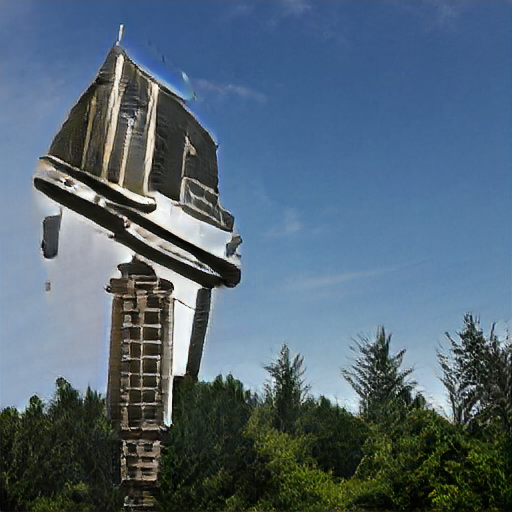

[tensor(4.4848, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2326, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-30.8906, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 25


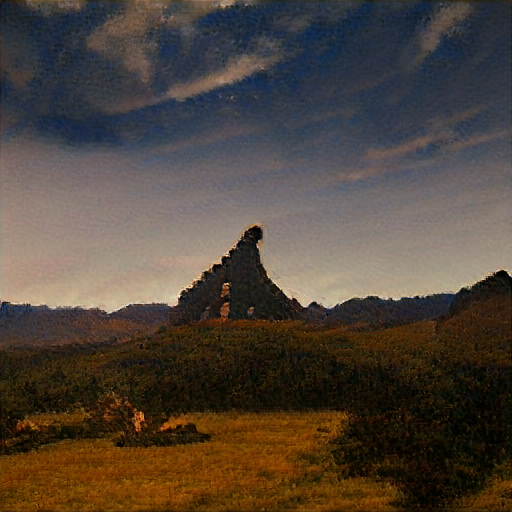

[tensor(4.2209, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1310, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-35.9688, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 50


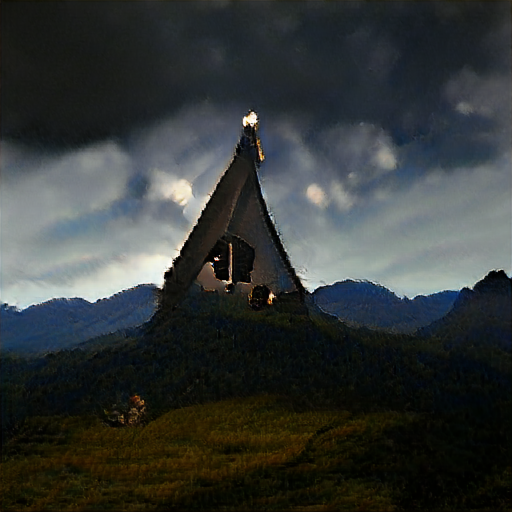

[tensor(4.2069, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1027, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-38., device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 75


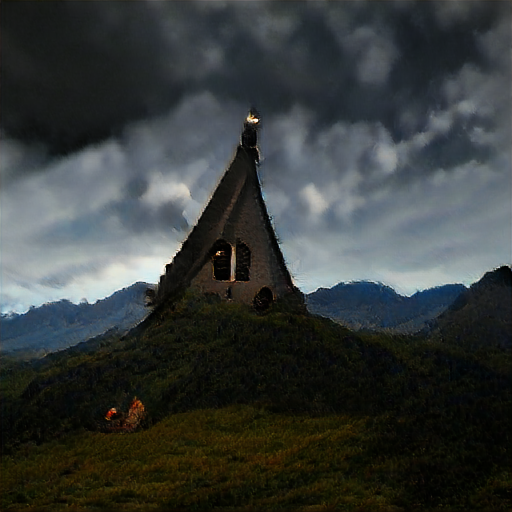

[tensor(4.2150, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0843, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-38.1562, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 100


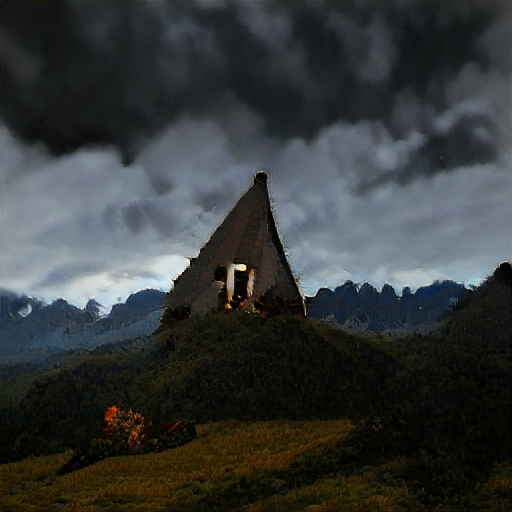

[tensor(4.1527, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0876, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-40.2188, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 125


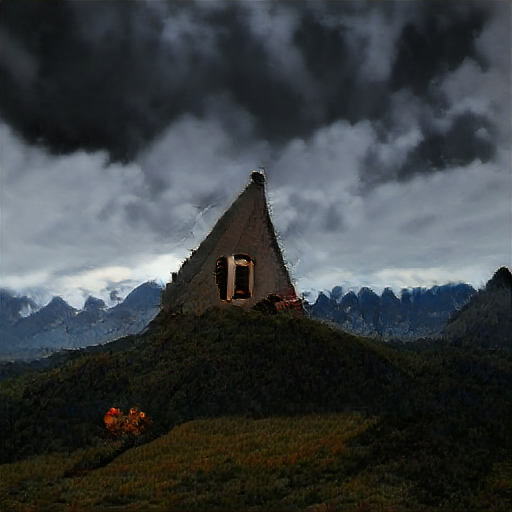

[tensor(4.1262, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0847, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-40.8125, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 150


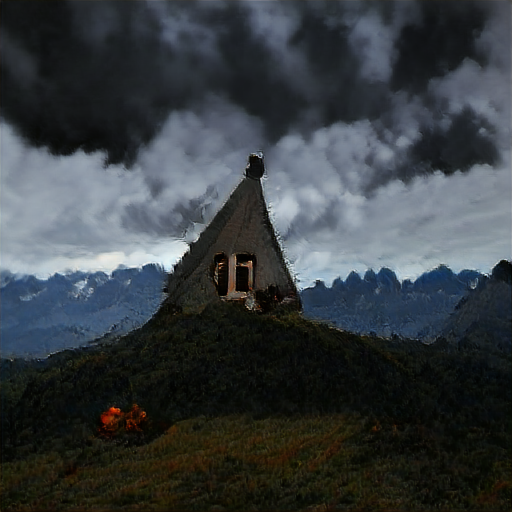

[tensor(4.1349, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0664, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-41.5625, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 175


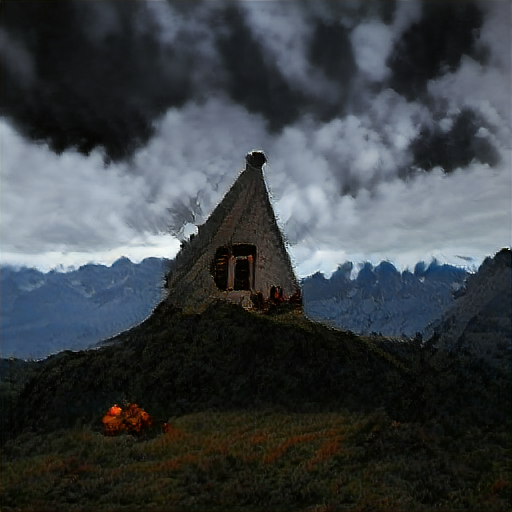

[tensor(4.1215, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-42.9062, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 200


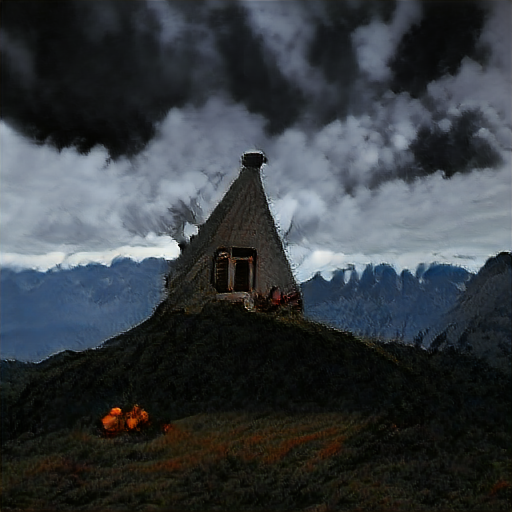

[tensor(4.1243, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0535, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-42.7500, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]
Displaying Iteration 225


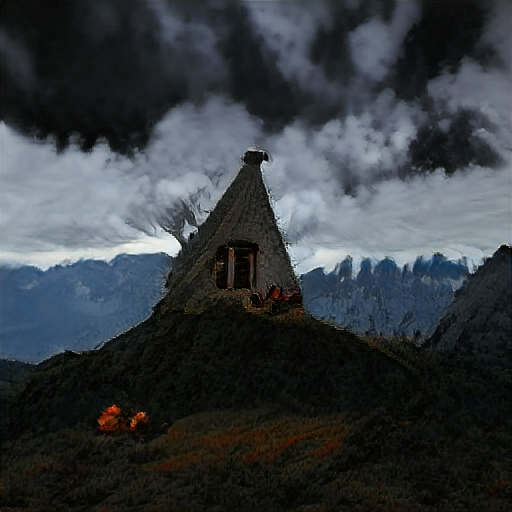

KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm

#@markdown Your text prompt to maximize:
promptInputMaximize = "a witches hut overlooking the mountains" #@param{type:"string"}
#@markdown Your text prompt to minimize:
promptInputMinimize = "" #@param{type:"string"}
#@markdown Show latest trained image every n interations:
displ_freq = 25 #@param{type:"number"}
#@markdown Save all progress images to a GDrive folder with the name of the prompt:
save_imgs = False #@param{type:"boolean"}
SEED = 42 #@param{type:"number"}
#@markdown Classes names and weights, seperated by a comma (should sum to 1.0, inspired by /u/Wiskkey):
classes_names = "bell, alp, church" #@param{type:"string"}
classes_weights = "0.3, 0.5, 0.2" #@param{type:"string"}

#@markdown Class Noise settings:
use_class_noise = True #@param{type:"boolean"}
noise_mean = 0 #@param{type:"number"}
noise_std = 4 #@param{type:"number"}

# Set prompt
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

txMs = []
if promptInputMaximize != "":
  for prompt in promptInputMaximize.split("\\"):
    txMs.append(clip.tokenize(f'''{prompt}'''))

txIs = []
if promptInputMinimize != "":
  for prompt in promptInputMinimize.split("\\"):
    txIs.append(clip.tokenize(f'''{prompt}'''))

# LATENT COORDINATE DEFINES

class Pars(torch.nn.Module):
    def __init__(self):
        from scipy.stats import truncnorm
        super(Pars, self).__init__()

        self.normu = torch.nn.Parameter(torch.zeros(16, 128).normal_(std=1).cuda())
 
        params_other = np.zeros(shape=(16,1000), dtype=np.float32)
        
        global classes_names
        global classes_weights

        if len(classes_names) != 0:

          classes_names = [s if s[0] != " " else s[1:] for s in classes_names.split(",")] 
          
          non_default_classes = [class_name_dict[name] for name in classes_names]
          non_default_classes = np.array(non_default_classes, dtype=np.int)
          
          classes_weights = classes_weights.replace(" ","").split(",")
          classes_weights = [float(num) for num in classes_weights]
          classes_weights = np.array(classes_weights, dtype=np.float32)

        else:
          
          non_default_classes = np.array([np.random.randint(0,999) for i in range(3)], dtype=np.int)
          classes_weights = np.array([0.4,0.3,0.3], dtype=np.float32)

        for i in range(non_default_classes.size):
              class_num= non_default_classes[i]
              class_value=classes_weights[i]
              params_other[:,class_num] = class_value
        
        
        if use_class_noise:
          noise_vec = torch.zeros(16, 1000).normal_(noise_mean, noise_std).abs().clip(0,15)
          for i in range(non_default_classes.size):
              class_num=non_default_classes[i]
              noise_vec[:,class_num] = 0
          
        else:
          noise_vec = torch.zeros(16, 1000)

        eps=1e-8
        params_other = np.log(params_other+eps)
        params_other = torch.tensor(params_other) + noise_vec
        params_other = torch.tensor(params_other, requires_grad=True, device='cuda')
        
        self.cls = torch.nn.Parameter(params_other)
        self.thrsh_lat = torch.tensor(1).cuda()
        self.thrsh_cls = torch.tensor(1.9).cuda()
 
 
 
    def forward(self):
      return self.normu, torch.softmax(self.cls,-1)

# LATENT COORDINATE FUNCTIONS

torch.manual_seed(SEED)

lats = Pars().cuda()
print("NORMU")
print(lats.normu.shape)
print("CLS")
print(lats.cls.shape)
optimizer = torch.optim.Adam(lats.parameters(), .07)
eps = 0

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

tMs = []
for txM in txMs:
  tMs.append(perceptor.encode_text(txM.cuda()).detach().clone())

tIs = []
for txI in txIs:
  tIs.append(perceptor.encode_text(txI.cuda()).detach().clone())

with torch.no_grad():
  al = (model(*lats(), 1).cpu()).numpy()

import datetime


if save_imgs:
  now = datetime.datetime.now()
  nowStr = now.strftime("%Y-%m-%d %H-%M-%S")
  folderName = f"{prompt}-progress {nowStr}"
  savePath = os.path.join(drivePath, folderName)
  !mkdir "$savePath"

itt = 0

def checkin(loss):
  print(loss)
  best = torch.topk(loss[2], k=1, largest=False)[1]
  with torch.no_grad():
    al = model(*lats(), 1)[best:best+1].cpu().numpy()
  for allls in al:
    if save_imgs:
      displSample(allls, os.path.join(savePath, f"{itt:05}.png"))
    else:
      displSample(allls, "")
    display.display(display.Image(str(3)+'.png'))
    print('\n')

def ascend_txt():
  out = model(*lats(), 1)

  cutn = 128
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .95))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='nearest')
    p_s.append(apper)
  into = torch.cat(p_s, 0)

  into = nom((into + 1) / 2)
  iii = perceptor.encode_image(into)
  llls = lats()
  lat_l = torch.abs(1 - torch.std(llls[0], dim=1)).mean() + \
  torch.abs(torch.mean(llls[0])).mean() + \
  4*torch.max(torch.square(llls[0]).mean(), lats.thrsh_lat)

  for array in llls[0]:
    mean = torch.mean(array)
    diffs = array - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0
    lat_l = lat_l + torch.abs(kurtoses) / llls[0].shape[0] + torch.abs(skews) / llls[0].shape[0]

  cls_l = ((50*torch.topk(llls[1],largest=False,dim=1,k=999)[0])**2).mean()
  result = [lat_l, cls_l]

  for t in tMs:
    result.append(-100*torch.cosine_similarity(t, iii, dim=-1).mean())
  for t in tIs:
    result.append(100*torch.cosine_similarity(t, iii, dim=-1).mean())
  return result

def train(epoch, i):
  lossAll = ascend_txt()
  loss = sum(lossAll)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if itt % displ_freq == 0:
    checkin(lossAll)

itt = 0
for epochs in range(10000):
  for i in tqdm(range(50000)):
    train(eps, i)
    itt+=1
  eps+=1
